In [1]:
import numpy as np
import gym
import cartpole_swingup_envs
from pilco.models import PILCO
from pilco.controllers import RbfController
from pilco.rewards import ExponentialReward
import tensorflow as tf
from gpflow import set_trainable
import os
import random

SEED = 0

os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

from utils import rollout

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

tf.config.set_visible_devices([], 'GPU') # Disable GPU

In [2]:
env = gym.make('CartPoleSwingUpContinuous-v0')
env.seed(SEED)
env.action_space.seed(SEED)

SUBS = 5  # subsampling rate
T = 30  # the number of timesteps (for planning, training, and testing)
J = 3  # the number of random rollouts before optimisation starts

max_action = 1.0  # the maximum possible value that action can take

# Hyper-parameters of the reward function (this is tricky to tune!)
target = np.array([0.0, 0.05, 1.0, 0.0, 0.05])
weights = np.diag([0.1, 0.1, 2.0, 2.0, 0.1])

# Initial parameters of the GP model of the environment
m_init = np.reshape([0.0, 0.0, -1.0, 0.0, 0.0], (1,5))
S_init = np.diag([0.05, 0.05, 0.01, 0.01, 0.01])

In [3]:
# Random rollouts
X,Y, _, _ = rollout(env, None, timesteps=T, verbose=False, random=True, SUBS=SUBS, render=False)
for i in range(1,J):
    X_, Y_, _, _ = rollout(env, None, timesteps=T, verbose=False, random=True, SUBS=SUBS, render=False)
    X = np.vstack((X, X_))
    Y = np.vstack((Y, Y_))

state_dim = Y.shape[1]  # state = (x, x_dot, cos(theta), sin(theta), theta_dot)
control_dim = X.shape[1] - state_dim
print(state_dim, control_dim)

5 1


In [4]:
controller = RbfController(state_dim=state_dim, control_dim=control_dim, num_basis_functions=30, max_action=max_action)
R = ExponentialReward(state_dim=state_dim, t=target, W=weights)
pilco = PILCO((X, Y), controller=controller, horizon=T, reward=R, m_init=m_init, S_init=S_init)

# fix the likelihood variance parameters of the GP models for numerical stability
for model in pilco.mgpr.models:
    model.likelihood.variance.assign(0.001) # 0.001
    set_trainable(model.likelihood.variance, False)

# Training model and policy
pilco.optimize_models(maxiter=50, restarts=1)
pilco.optimize_policy(maxiter=50, restarts=1)

# Rollout using the pilco controller
X_new, Y_new, _, _ = rollout(env, pilco, timesteps=T, SUBS=SUBS, render=False)

-----Learned models------
---Lengthscales---
      GP0     GP1     GP2     GP3     GP4
0   9.061  20.415  19.779  20.803  16.700
1   5.068  28.888  27.052  28.498  31.804
2   9.489   2.011   1.542   1.512   0.959
3   6.832   1.141   1.595   1.555   0.937
4  23.695  10.559  12.838  12.741   9.860
5   5.529   3.291   7.768   5.762   2.586
---Variances---
     GP0    GP1    GP2    GP3     GP4
0  0.041  3.671  0.526  0.597  10.557
---Noises---
     GP0    GP1    GP2    GP3    GP4
0  0.001  0.001  0.001  0.001  0.001
Controller's optimization: done in 28.0 seconds with reward=8.688.
Action:  tf.Tensor([-0.66329072], shape=(1,), dtype=float64)
State :  [-0.00882108 -1.19272496 -0.99932438 -0.03675294  2.48525259]
Return so far:  0.0018514836498690827
Action:  tf.Tensor([-0.47527033], shape=(1,), dtype=float64)
State :  [-0.15464003 -1.79765776 -0.94190753 -0.33587231  3.61590899]
Return so far:  0.06653912689266052
Action:  tf.Tensor([0.11311082], shape=(1,), dtype=float64)
State :  [-0.3154

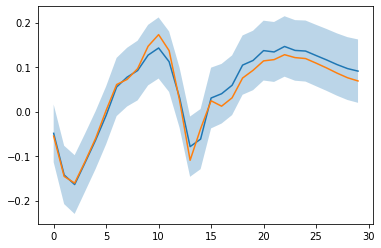

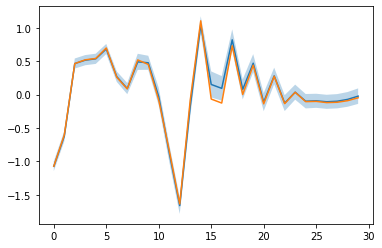

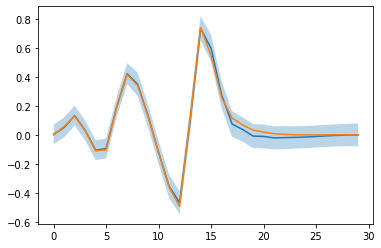

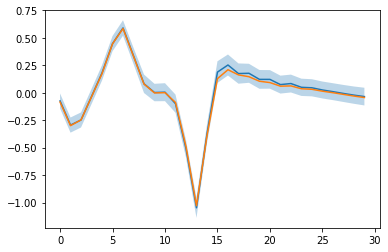

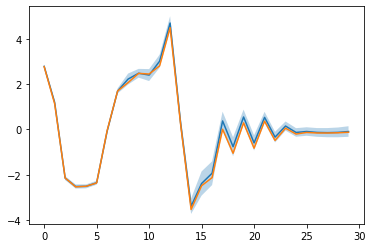

In [5]:
for i,m in enumerate(pilco.mgpr.models):
    y_pred_test, var_pred_test = m.predict_y(X_new)
    plt.plot(range(len(y_pred_test)), y_pred_test, Y_new[:,i])
    plt.fill_between(range(len(y_pred_test)),
                       y_pred_test[:,0] - 2*np.sqrt(var_pred_test[:, 0]), 
                       y_pred_test[:,0] + 2*np.sqrt(var_pred_test[:, 0]), alpha=0.3)
    plt.show()
    
#np.shape(var_pred_test)

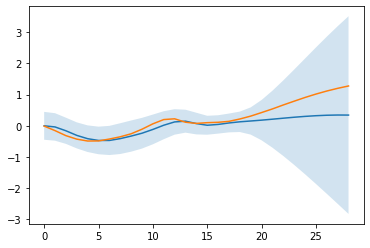

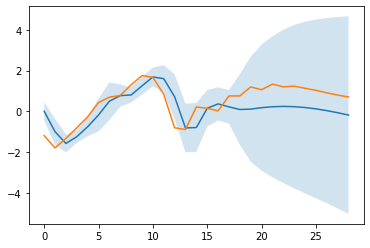

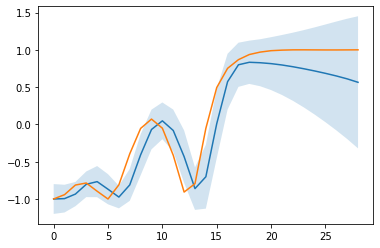

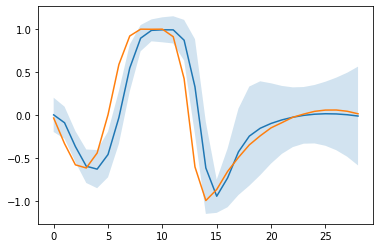

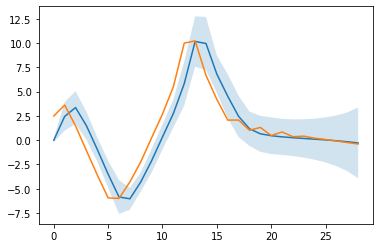

In [6]:
m_p = np.zeros((T, state_dim))
S_p = np.zeros((T, state_dim, state_dim))

m_p[0,:] = m_init
S_p[0, :, :] = S_init

for h in range(1, T):
    m_p[h,:], S_p[h,:,:] = pilco.propagate(m_p[h-1, None, :], S_p[h-1,:,:])
    

for i in range(state_dim):    
    plt.plot(range(T-1), m_p[0:T-1, i], X_new[1:T, i]) # can't use Y_new because it stores differences (Dx)
    plt.fill_between(range(T-1),
                     m_p[0:T-1, i] - 2*np.sqrt(S_p[0:T-1, i, i]),
                     m_p[0:T-1, i] + 2*np.sqrt(S_p[0:T-1, i, i]), alpha=0.2)
    plt.show()